# Sentiment analysis on Covid-19 tweets with BERT

Note: the relevant preprocessing steps for the input file used in this notebook are implemented in the notebook "nlp_deeplearning.ipynb"

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import string
import joblib

from warnings import filterwarnings
filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import collections
from collections import Counter
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

import transformers
from transformers import BertTokenizer, TFBertModel

# BERT 
BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained machine learning model for NLP tasks:

* Base model: 12-layers, 768-hidden, 12-heads, 110M parameter neural network
* Large model: 24-layer, 1024-hidden, 16-heads, 340M parameter neural network

A transformer is a deep learning model that adopts the mechanism of attention, differentially weighting the significance of each part of the input data. Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, although they do not necessarily process the data in order. Rather, the attention mechanism helps the transformer encoder identify the contextual relations between words in a text. This feature allows for more parallelization than RNNs and therefore reduces training times.

The transformer encoder takes as input a sequence of tokens, which are embedded into real-valued vectors and processed in the neural network. 

Training strategies: 

* Masked LM (MLM): before processing word sequences, 15% of the words in each sequence are masked, so that the model attempts to predict the masked tokens based on the context. 
* Next sentence prediction (NSP): the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document.

When training the BERT model, Masked LM and Next Sentence Prediction are trained together, with the goal of minimizing the combined loss function of the two strategies.

-----------------------------------------------------------------------------------------------------

Before being used by BERT as inputs, the tweets are preprocessed using the transformers encoder: 

* input ids: token indices, i.e. numerical representations of token sequences that will be used as input by the model
* attention mask: optional argument, indicates which tokens should be attended to and which should not. Sequences of different lengths are padded/sliced until they are of the same dimension; the attention mask indicates the position of the padded indices, so that the model knows which token ids to ignore.

In [3]:
df = pd.read_csv("./input/data_deeplearning.csv")

In [4]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

28444 7111


In [5]:
# split dataset
X_train = df.head(train_size).tweet_clean 
y_train = df.head(train_size).target_encoded

X_test = df.tail(test_size).tweet_clean
y_test = df.tail(test_size).target_encoded

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (28444,) (28444,)
Testing data X, y: (7111,) (7111,)


In [6]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35  

In [7]:
# load pre-trained bert tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2021-12-08 19:30:10.341543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 19:30:10.342747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 19:30:10.343420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 19:30:10.344217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
def inputs_bert(data, sequence_length):
    """ preprocess text for BERT model input """
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
        text, 
        add_special_tokens=True,
        max_length=sequence_length, #set max length of tokens equal to median tweet length
        pad_to_max_length=True,
        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [9]:
train_input_ids, train_attention_masks = inputs_bert(X_train, sequence_length)
test_input_ids, test_attention_masks = inputs_bert(X_test, sequence_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
# add dense layer and output layer to pre-trained model and train only those
input_ids = tf.keras.Input(shape=(sequence_length,),dtype='int32')
attention_masks = tf.keras.Input(shape=(sequence_length,),dtype='int32')

output = bert_model([input_ids, attention_masks])
output = output[1]
output = tf.keras.layers.Dense(sequence_length, activation='relu')(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data = ([test_input_ids, test_attention_masks], y_test), 
    epochs=3,
    batch_size=32)

2021-12-08 19:31:15.999821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
889/889 [==============================] - 171s 176ms/step - loss: 0.4821 - accuracy: 0.7722 - val_loss: 0.3623 - val_accuracy: 0.8402
Epoch 2/3
889/889 [==============================] - 154s 173ms/step - loss: 0.3285 - accuracy: 0.8635 - val_loss: 0.3128 - val_accuracy: 0.8661
Epoch 3/3
889/889 [==============================] - 154s 173ms/step - loss: 0.2584 - accuracy: 0.8999 - val_loss: 0.3170 - val_accuracy: 0.8651


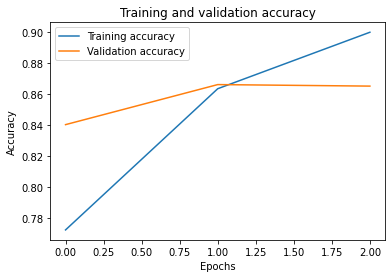

In [13]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

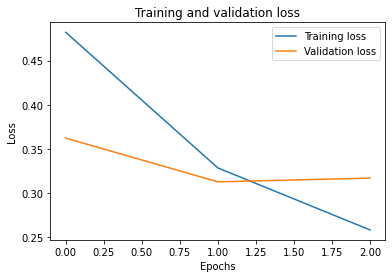

In [14]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()